# Capped Trend Accumulator 評価

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.ios import get_excel_sheet
from funcs.technical import CappedTrendAccumulator, MovingRange
from funcs.tide import conv_datetime_from_timestamp

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 10

## ティックデータの取得

In [4]:
# excel = "ticks_20251212.xlsx"
# excel = "ticks_20251229.xlsx"
excel = "ticks_20251230.xlsx"
code = "7011"  # 銘柄コード

path_dir = os.path.join("..", "collection")
path_excel = os.path.join(path_dir, excel)
df = get_excel_sheet(path_excel, code)
df

,Time,Price,Volume
0,1.767053e+09,3850,314100
1,1.767053e+09,3850,314100
2,1.767053e+09,3857,344900
3,1.767053e+09,3857,344900
4,1.767053e+09,3847,371300
...,...,...,...
19439,1.767076e+09,3844,8350600
19440,1.767076e+09,3844,8350600
19441,1.767076e+09,3844,8350600
19442,1.767076e+09,3844,8361300


In [5]:
df.index = [pd.to_datetime(conv_datetime_from_timestamp(ts)) for ts in df["Time"]]
df

,Time,Price,Volume
2025-12-30 09:00:04,1.767053e+09,3850,314100
2025-12-30 09:00:05,1.767053e+09,3850,314100
2025-12-30 09:00:06,1.767053e+09,3857,344900
2025-12-30 09:00:07,1.767053e+09,3857,344900
2025-12-30 09:00:08,1.767053e+09,3847,371300
...,...,...,...
2025-12-30 15:24:45,1.767076e+09,3844,8350600
2025-12-30 15:24:46,1.767076e+09,3844,8350600
2025-12-30 15:24:47,1.767076e+09,3844,8350600
2025-12-30 15:24:48,1.767076e+09,3844,8361300


## MR と CTA

In [6]:
# Capped Price Movement
period = 30
mr = MovingRange(window_size=period)
df["MR"] = [mr.update(v) for v in df["Price"]]
cta = CappedTrendAccumulator(window_size=period)
df["CTA"] = [cta.update(v) for v in df["Price"]]
df

,Time,Price,Volume,MR,CTA
2025-12-30 09:00:04,1.767053e+09,3850,314100,0,0.0
2025-12-30 09:00:05,1.767053e+09,3850,314100,0,0.0
2025-12-30 09:00:06,1.767053e+09,3857,344900,7,2.0
2025-12-30 09:00:07,1.767053e+09,3857,344900,7,2.0
2025-12-30 09:00:08,1.767053e+09,3847,371300,10,0.0
...,...,...,...,...,...
2025-12-30 15:24:45,1.767076e+09,3844,8350600,3,1.0
2025-12-30 15:24:46,1.767076e+09,3844,8350600,3,1.0
2025-12-30 15:24:47,1.767076e+09,3844,8350600,3,1.0
2025-12-30 15:24:48,1.767076e+09,3844,8361300,3,1.0


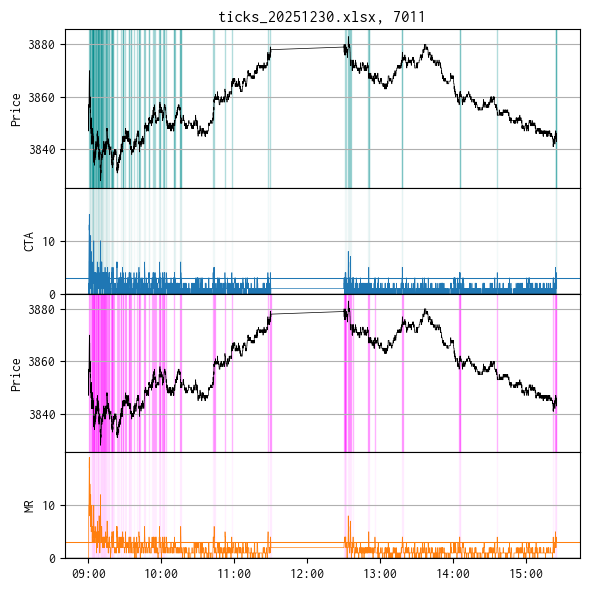

In [7]:
threshold = 3
x = df.index

fig = plt.figure(figsize=(6, 6))
n = 4
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1.5 if i % 2 == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis

ax[0].plot(df["Price"], linewidth=0.5, color="black", alpha=1)
ax[0].set_ylabel("Price")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{excel}, {code}")
ax[0].grid(axis="y")

ax[1].plot(df["CTA"], linewidth=0.5, color="C0")
ax[1].axhline(y=threshold, linewidth=0.75, color="C0")
ax[1].axhline(0, linewidth=0.25, color="black")
ax[1].set_ylabel("CTA")
ax[1].grid(axis="y")
y = df["CTA"]
ax[0].fill_between(
    x, 0, 1,
    where=(threshold < y),
    color="darkcyan",
    alpha=0.3,
    transform=ax[0].get_xaxis_transform(),
)
ax[1].fill_between(
    x, 0, 1,
    where=(threshold < y),
    color="darkcyan",
    alpha=0.05,
    transform=ax[1].get_xaxis_transform(),
)

ax[2].plot(df["Price"], linewidth=0.5, color="black", alpha=1)
ax[2].set_ylabel("Price")
ax[2].grid(axis="y")

ax[3].plot(df["MR"], linewidth=0.5, color="C1")
ax[3].axhline(y=threshold, linewidth=0.75, color="C1")
ax[3].axhline(0, linewidth=0.25, color="black")
ax[3].set_ylabel("MR")
ax[3].grid(axis="y")
y = df["MR"]
ax[2].fill_between(
    x, 0, 1,
    where=(threshold < y),
    color="magenta",
    alpha=0.3,
    transform=ax[2].get_xaxis_transform(),
)
ax[3].fill_between(
    x, 0, 1,
    where=(threshold < y),
    color="magenta",
    alpha=0.05,
    transform=ax[3].get_xaxis_transform(),
)

_, y_max_1 = ax[1].get_ylim()
_, y_max_2 = ax[3].get_ylim()
y_max = max(y_max_1, y_max_2)
ax[1].set_ylim(0, y_max)
ax[3].set_ylim(0, y_max)

plt.tight_layout()
output = os.path.join("..", "tmp", "mr_cta.png")
plt.savefig(output)
plt.show()

In [8]:
df_hist = pd.DataFrame(df[["MR", "CTA"]].stack()).reset_index()
df_hist.columns = ["Timpestamp", "idx", "value_ma"]
df_hist = df_hist.sort_values(["value_ma", "idx"])
df_hist["value_ma"] = df_hist["value_ma"].astype(int).astype(str)

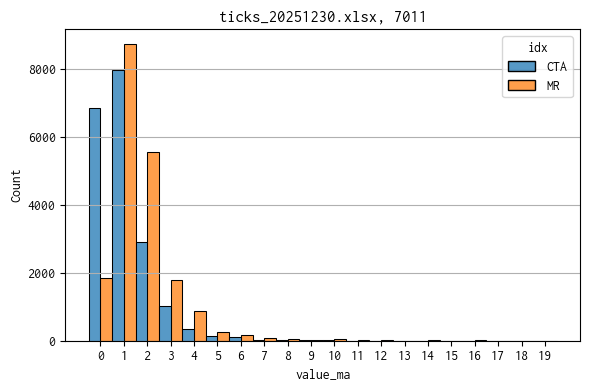

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df_hist, x="value_ma", hue="idx", multiple="dodge", ax=ax)
ax.set_title(f"{excel}, {code}")
ax.grid(axis="y")

plt.tight_layout()
output = os.path.join("..", "tmp", "hist_mr_cta.png")
plt.savefig(output)
plt.show()